## Introduction
This Jupyter Notebook aims to analyze the provided datasets `events.csv` and `games.csv`  to derive insights for pricing bets on goals in football matches. The notebook covers steps for data loading, merging, exploratory data analysis (EDA), and basic visualization of goal distributions.
The final df is saved as for further use of feature selection and model prediction.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder

Read data and get some basic info

In [2]:
events_df = pd.read_csv('../data/events.csv')
print("Events Dataset:")
print(events_df.info())
print(events_df.describe())
events_df.head(1)

Events Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748951 entries, 0 to 748950
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  748951 non-null  int64 
 1   game_id     748951 non-null  int64 
 2   minute      748951 non-null  int64 
 3   scoreAway   748951 non-null  int64 
 4   scoreHome   748951 non-null  int64 
 5   second      748951 non-null  int64 
 6   state       748951 non-null  object
 7   type        748951 non-null  object
dtypes: int64(6), object(2)
memory usage: 45.7+ MB
None
          Unnamed: 0       game_id         minute      scoreAway  \
count  748951.000000  7.489510e+05  748951.000000  748951.000000   
mean   374475.000000  9.400677e+05      49.307989       0.727602   
std    216203.675066  6.380112e+04      27.291816       1.048997   
min         0.000000  7.030470e+05       1.000000       0.000000   
25%    187237.500000  8.823290e+05      26.000000       0.000000   


Unnamed: 0  game_id  minute  scoreAway  scoreHome  second          state  \
0           0   703047      14          0          1       0  RT_FIRST_HALF   

        type  
0  GOAL_HOME

### Data Preprocessing
1- drop un0informative column
2- preprocess column names and sort
3- Encode the event type as ['no-event', 'goal_home', 'goal_away', 'corner_home', 'corner_away']

In [3]:
# Drop the Unnamed column
events_df = events_df.loc[:, "game_id":]

# Make all string columns lower case to be consistent
events_df.state = events_df.state.str.lower()
events_df.type = events_df.type.str.lower()
events_df.sort_values(by=["game_id", "minute", "second"], inplace=True)

# Encode event types into numerical values, with 0 as no event
event_encoding = {'goal_home': 1, 'goal_away': 2, 'corner_home': 3, 'corner_away': 4}
events_df['type_encoded'] = events_df['type'].map(event_encoding)

In [4]:
events_df

game_id  minute  scoreAway  scoreHome  second           state  \
0        703047      14          0          1       0   rt_first_half   
1        703047      27          0          1       0   rt_first_half   
2        703047      32          0          1       0   rt_first_half   
3        703047      38          0          1       0   rt_first_half   
4        703047      38          0          2       0   rt_first_half   
...         ...     ...        ...        ...     ...             ...   
747170  1079284      61          0          0      44  rt_second_half   
747171  1079284      64          0          0      45  rt_second_half   
747172  1079284      73          0          0      37  rt_second_half   
747173  1079284      75          0          0      49  rt_second_half   
747174  1079284      78          1          0      53  rt_second_half   

               type  type_encoded  
0         goal_home             1  
1       corner_home             3  
2       corner_home             3  
3       corner_home             3  
4         goal_home             1  
...             ...           ...  
747170  corner_home             3  
747171  corner_away             4  
747172  corner_away             4  
747173  corner_away             4  
747174    goal_away             2  

[748951 rows x 8 columns]

### Initial EDA on events dataset
plot the distribution of type and event times to gain insight on the frequency of specific events in specific states of the game

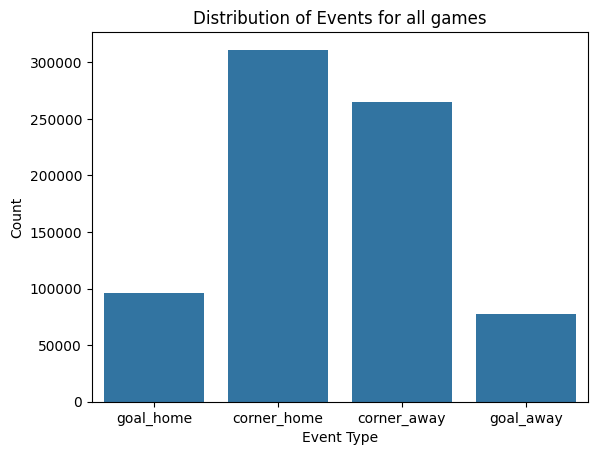

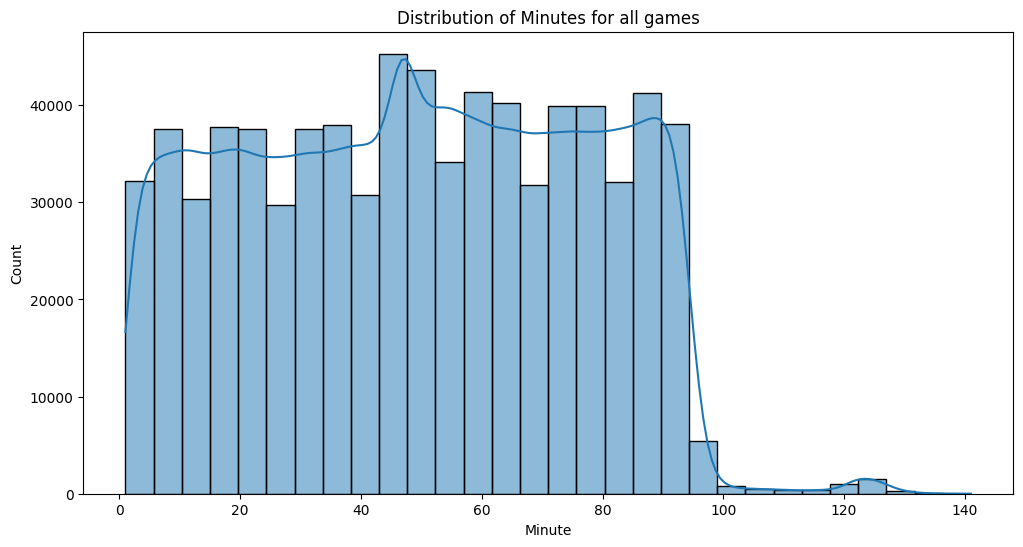

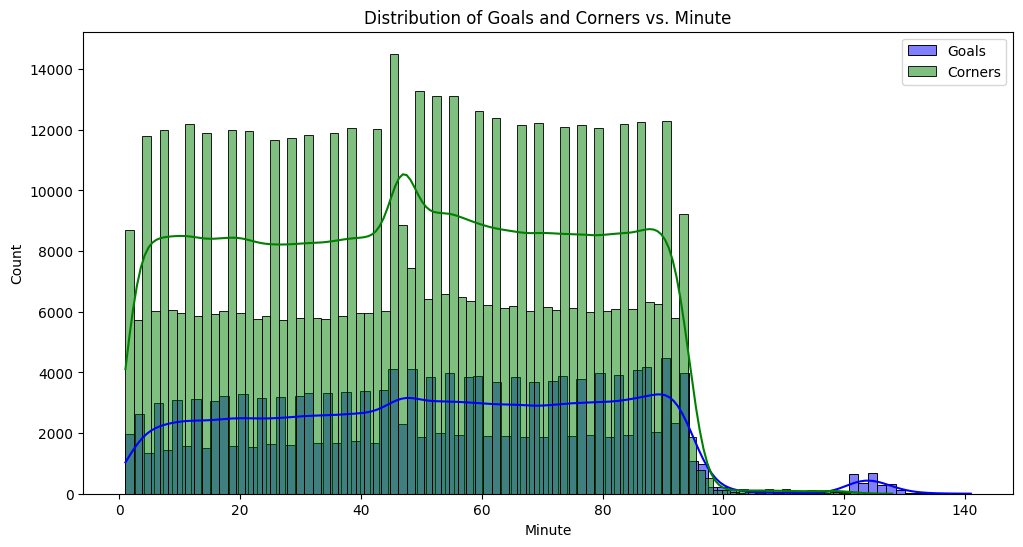

In [5]:
# Plot distribution of 'type'
plt.figure()
sns.countplot(data=events_df, x='type')
plt.title('Distribution of Events for all games')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Plot distribution of 'minute'
plt.figure(figsize=(12, 6))
sns.histplot(data=events_df, x='minute', bins=30, kde=True)
plt.title('Distribution of Minutes for all games')
plt.xlabel('Minute')
plt.ylabel('Count')
plt.show()

# Plot distribution of goals and corners vs. minute
goals = events_df[events_df['type'].str.startswith('goal')]
corners = events_df[events_df['type'].str.startswith('corner')]

plt.figure(figsize=(12, 6))
sns.histplot(data=goals, x='minute', bins=90, color='blue', label='Goals', kde=True)
sns.histplot(data=corners, x='minute', bins=90, color='green', label='Corners', kde=True)
plt.title('Distribution of Goals and Corners vs. Minute')
plt.xlabel('Minute')
plt.ylabel('Count')
plt.legend()
plt.show()

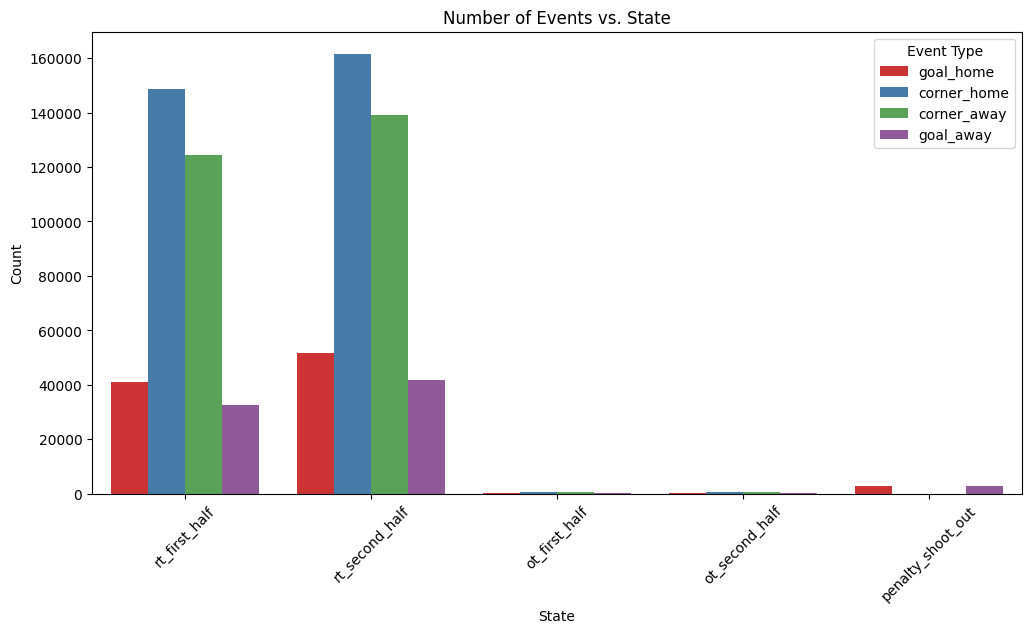

In [6]:
# Plot number of events vs. each state
plt.figure(figsize=(12, 6))
sns.countplot(data=events_df, x='state', hue='type', palette='Set1')
plt.title('Number of Events vs. State')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Event Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

According to the depicted graphs, it appears that home teams tend to both score more goals and earn more corner kicks. As anticipated, a significant majority of events take place during regular game time, with only goals occurring during penalty time. There seems to be a rise in goal occurrences during the final minutes of the first half, and a slight uptick in overall events during the second half.

Create Sequence for each game to speed up feature engineering

Here, we generate time series sequences for each game, with a minute-by-minute granularity, based on the events and their precise minute of occurrence. We use the encoding ['no-event', 'goal_home', 'goal_away', 'corner_home', 'corner_away'] to represent the events in the time series.

In [7]:
# Get corresponding index for each game id to optimize the sequence creation with arrays
events_df['idx'], _ = pd.factorize(events_df['game_id'])

#initialize the sequence with zero as no events
sequences = np.zeros((len(events_df['game_id'].unique()), events_df["minute"].max()))

# Loop through each event and update the corresponding minute in the sequence with type_encoded
for idx, row in events_df.iterrows():
    sequences[row['idx'], row['minute'] - 1] = row['type_encoded']

sequences = sequences.astype(int)
print(sequences.shape)

(59044, 141)


For Exploratory Data Analysis (EDA) on the padded sequences, we can analyze various aspects of the data to gain insights into the distribution and patterns of events in football games.



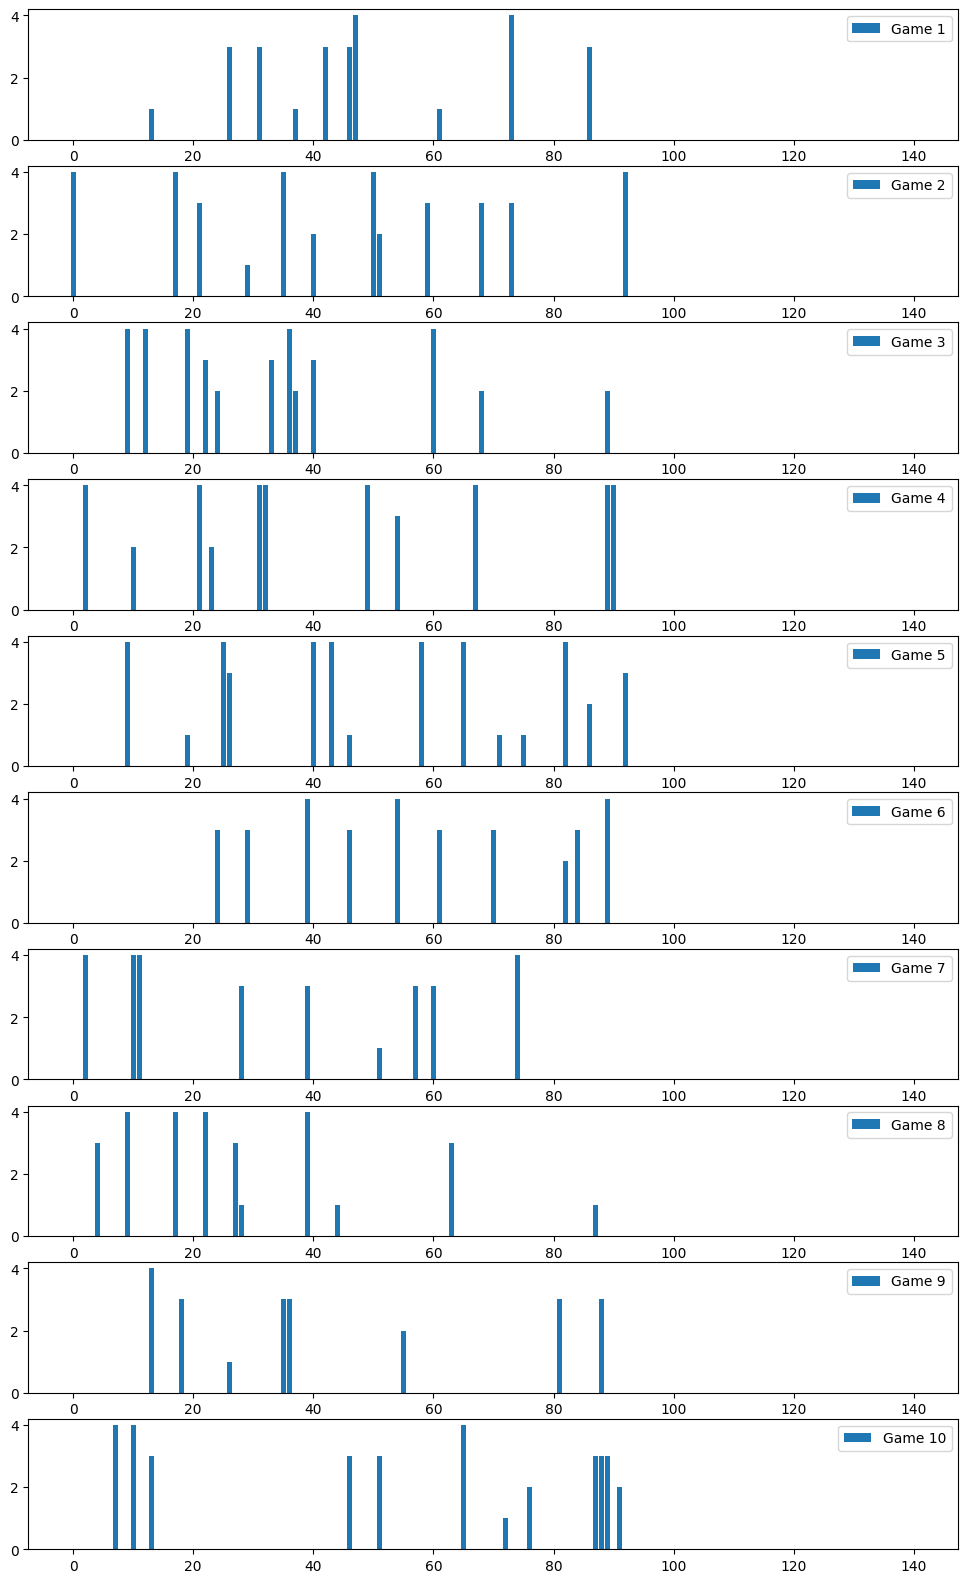

In [8]:
df = pd.DataFrame(sequences)
event_encoding = {'goal_home': 1, 'goal_away': 2, 'corner_home': 3, 'corner_away': 4}

plt.figure(figsize=(12, 20))
for i in range(10):  # Plot data for 3 games
    plt.subplot(10, 1, i+1)  # Subplot with 3 rows, 1 column, and i+1 index
    plt.bar(np.arange(df.shape[1]), df.iloc[i], label=f'Game {i+1}')
    plt.legend()
plt.show()

In [9]:
seq_df = pd.DataFrame(sequences) 
seq_df['game_id'] = events_df['game_id'].unique() # add the game_id to the created feature dataframe
print(seq_df.shape)
seq_df.head(4)

(59044, 142)


0  1  2  3  4  5  6  7  8  9  ...  132  133  134  135  136  137  138  139  \
0  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  4  ...    0    0    0    0    0    0    0    0   
3  0  0  4  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   140  game_id  
0    0   703047  
1    0   705604  
2    0   708382  
3    0   719093  

[4 rows x 142 columns]

### Feature Engineering
Since the events sequence is very sparse, fitting a LSTM or RNN might easily result biased results towards the majority event (which is no event). So feature engineerings seems like a good idea.

purpose is to produce features, given any sequence. So the generated features are independant of the length of the sequence and so can be generated for any given dataset.

In [10]:
## Helper functions

def get_event_num(arrays, event_Code):
    """Get away corners in the game sequences

    :param arrays: list of game sequences
    :param event_Code: (int), either 1:goal_home, 2:goal_away, 3:corner_home, 4:corner_away
    """
    return [np.count_nonzero(arr == event_Code) for arr in arrays]       

def event_freq(num_event, arrays):
    """Get freuqency of the event in comparison to game duration

    :param num_event: (list) list of integers:calculated occurances of the event so far
    :param arrays: list of game sequences
    """
    sizes = np.array([arr.size for arr in arrays])
    return num_event/sizes

def mean_std_intervals(arr, event_code):
    """mean and standard deviation of distances of consecutive occurrences

    :param arr: 2d matrix of game sequences
    :param event_Code: (int), either 1:goal_home, 2:goal_away, 3:corner_home, 4:corner_away
    """
    mean_lst = []
    std_lst = []
    intervals = []
    for row in arr:
        intervals = []
        fours_indices = np.where(row == event_code)[0] # find all occurances indices of event
        if len(fours_indices) >= 2: # if more than 2 occurances
            intervals.extend(np.diff(fours_indices))
        else:
            intervals = [0]
        mean_lst.append(np.mean(intervals))
        std_lst.append(np.std(intervals))
        
    events = ['goal_h', 'goal_a', 'corner_h', 'corner_a']
    return {f"mean_{events[event_code-1]}_intervals": mean_lst, f"std_{events[event_code-1]}_intervals": std_lst}

def events_feature_generation(arrays, game_id_list):
    """Generate all event based features for the given set of sequences

    :param arrays: 2d matrix of game sequences
    :param game_id_list: (list of strings) list of game ids to be concated to the dataframe
    """
    data = pd.DataFrame({
        'home_goals':get_event_num(arrays, 1),
        'away_goals':get_event_num(arrays, 2),
        'home_corners':get_event_num(arrays, 3),
        'away_corners':get_event_num(arrays, 4)
    })
    data = pd.concat([data, pd.DataFrame(mean_std_intervals(arrays, 1))], axis = 1)
    data = pd.concat([data, pd.DataFrame(mean_std_intervals(arrays, 2))], axis = 1)
    data = pd.concat([data, pd.DataFrame(mean_std_intervals(arrays, 3))], axis = 1)
    data = pd.concat([data, pd.DataFrame(mean_std_intervals(arrays, 4))], axis = 1)
    data["goal_h_freq"] = event_freq(data["home_goals"].values, arrays)
    data["goal_a_freq"] = event_freq(data["away_goals"].values, arrays)
    data["corner_h_freq"] = event_freq(data["home_corners"].values, arrays)
    data["corner_a_freq"] = event_freq(data["away_corners"].values, arrays)
    data['game_id'] = game_id_list
    return data


def extract_two_strings(match_string, splitter):
    """Extracts the two strings from athe given match string

    :param match_string: (str) the string containing two words separated by splitter.
    :param splitter: (str) the string which is used for splitting
    :return: (list) list of two strings, the two words before and after splitter.
    Example:
    >>> extract_team_names("Deportivo Saprissa v Club Sport Heredian", " v ")
    ['Deportivo Saprissa', 'Club Sport Heredian']

    >>> extract_team_names("a vs b", " v ")
    [a vs b]
    >>> extract_team_names("a b v c", " v ")
    ['a b', 'c']
    """
    # Split the match string at splitter and strip whitespace from team names
    names = [name.strip() for name in match_string.split(splitter)]
    
    # edge case if the two words are not extracted, return empty string
    if len(names) != 2:
        return match_string
    
    return names[:2]  # AMGIC: 2 to make sure the first two are only returned

### Create Dataset
for dataset creation, we choose random time stamps of the games to include all possible scenrios. We also need to import games.csv to get some features like team names and leagues from that csv file.
The two other important features to be added are game length so far and game length remained.

In [11]:
games_df = pd.read_csv('../data/games.csv')
# drop the Unnamed column
games_df = games_df.loc[:, "game_id":]

# make all string columns lowe case to be consistent
games_df.description = games_df.description.str.lower()
games_df.league = games_df.league.str.lower()
games_df.sort_values(by=["game_id","date"], inplace=True)
games_df.head(4)


game_id              date                                  description  \
0   703047  26/08/2016 13:00  fc dynamo kyiv u21 v fc vorskla poltava u21   
1   705604  30/08/2016 15:30       fc kiffen v hjk helsinki ii (klubi 04)   
3   708382  09/09/2016 14:00      fk desna chernihiv v fc kolos kovalivka   
2   719093  06/09/2016 14:30             fk lida v fc shakhtyor soligorsk   

                         league  
0          ukraine - u21 league  
1  finland - kakkonen - group b  
3         ukraine - persha liga  
2                 belarus - cup

In [12]:
# EXTRACT features from games_df
## Get team names from the description column
games_df[['team1', 'team2']] = games_df['description'].apply(lambda x: pd.Series(extract_two_strings(x, " v ")))
label_encoder = LabelEncoder() # econde team columms in place
games_df['encoded_team1'] = label_encoder.fit_transform(games_df['team1'])
games_df['encoded_team2'] = label_encoder.fit_transform(games_df['team2'])

## Get features from leauge description column
games_df['friendly'] = games_df['league'].apply(lambda x: 1 if "friendly" in x else 0)
games_df['u21'] = games_df['league'].apply(lambda x: 1 if "u21" in x else 0)
games_df['cup'] = games_df['league'].apply(lambda x: 1 if "cup" in x else 0)

# keep only features columns
games_df = games_df[['game_id', 'encoded_team1', 'encoded_team2', 'friendly', 'u21', 'cup']]
games_df.head(4)


game_id  encoded_team1  encoded_team2  friendly  u21  cup
0   703047           2563           3094         0    1    0
1   705604           2650           4067         0    0    0
3   708382           3025           2863         0    0    0
2   719093           3106           3001         0    0    1

In [13]:
# Given pred points, extract features from sequences dataframe
max_time = 90  # Investigating only first 90 mins
random.seed(42)

# timestamp of prediction point, resulting in complementary input and output seqs, with different sizes
pred_point = [random.randint(10, max_time-10) for _ in range(sequences.shape[0])]
input_sequence = [seq[0:point] for seq, point in zip(sequences, pred_point)]
input_events_df = events_feature_generation(input_sequence, events_df["game_id"].unique())
input_events_df["time_gone"] = np.array(pred_point)
input_events_df["time_left"] = max_time - np.array(pred_point)
input_events_df.head(4)

home_goals  away_goals  home_corners  away_corners  mean_goal_h_intervals  \
0           1           0             0             0                    0.0   
1           0           0             0             1                    0.0   
2           0           2             3             4                    0.0   
3           0           2             0             4                    0.0   

   std_goal_h_intervals  mean_goal_a_intervals  std_goal_a_intervals  \
0                   0.0                    0.0                   0.0   
1                   0.0                    0.0                   0.0   
2                   0.0                   13.0                   0.0   
3                   0.0                   13.0                   0.0   

   mean_corner_h_intervals  std_corner_h_intervals  mean_corner_a_intervals  \
0                      0.0                     0.0                      0.0   
1                      0.0                     0.0                      0.0   
2                      9.0                     2.0                      9.0   
3                      0.0                     0.0                     10.0   

   std_corner_a_intervals  goal_h_freq  goal_a_freq  corner_h_freq  \
0                0.000000     0.041667     0.000000       0.000000   
1                0.000000     0.000000     0.000000       0.000000   
2                5.887841     0.000000     0.044444       0.066667   
3                7.348469     0.000000     0.048780       0.000000   

   corner_a_freq  game_id  time_gone  time_left  
0       0.000000   703047         24         66  
1       0.076923   705604         13         77  
2       0.088889   708382         45         45  
3       0.097561   719093         41         49

In [14]:
# Generate ouput dataframe, we mainly use the home goals and away goals from this dataset as y
output_sequence = [seq[point:max_time+1] for seq, point in zip(sequences, pred_point)]
output_events_df = events_feature_generation(output_sequence, events_df["game_id"].unique())
output_events_df.head(4)

home_goals  away_goals  home_corners  away_corners  mean_goal_h_intervals  \
0           2           0             5             2                   24.0   
1           1           2             4             3                    0.0   
2           0           2             0             1                    0.0   
3           0           0             1             4                    0.0   

   std_goal_h_intervals  mean_goal_a_intervals  std_goal_a_intervals  \
0                   0.0                    0.0                   0.0   
1                   0.0                   11.0                   0.0   
2                   0.0                   21.0                   0.0   
3                   0.0                    0.0                   0.0   

   mean_corner_h_intervals  std_corner_h_intervals  mean_corner_a_intervals  \
0                15.000000               14.679918                26.000000   
1                17.333333               14.704497                16.500000   
2                 0.000000                0.000000                 0.000000   
3                 0.000000                0.000000                13.666667   

   std_corner_a_intervals  goal_h_freq  goal_a_freq  corner_h_freq  \
0                0.000000     0.029851     0.000000       0.074627   
1                1.500000     0.012821     0.025641       0.051282   
2                0.000000     0.000000     0.043478       0.000000   
3                9.104334     0.000000     0.000000       0.020000   

   corner_a_freq  game_id  
0       0.029851   703047  
1       0.038462   705604  
2       0.021739   708382  
3       0.080000   719093

In [15]:
# The dataset to work with
X = pd.merge(input_events_df, games_df, on='game_id')
X.sort_values('game_id', inplace=True)
X.set_index("game_id", inplace=True, drop=True)
X.head(4)


home_goals  away_goals  home_corners  away_corners  \
game_id                                                       
703047            1           0             0             0   
705604            0           0             0             1   
708382            0           2             3             4   
719093            0           2             0             4   

         mean_goal_h_intervals  std_goal_h_intervals  mean_goal_a_intervals  \
game_id                                                                       
703047                     0.0                   0.0                    0.0   
705604                     0.0                   0.0                    0.0   
708382                     0.0                   0.0                   13.0   
719093                     0.0                   0.0                   13.0   

         std_goal_a_intervals  mean_corner_h_intervals  \
game_id                                                  
703047                    0.0                      0.0   
705604                    0.0                      0.0   
708382                    0.0                      9.0   
719093                    0.0                      0.0   

         std_corner_h_intervals  ...  goal_a_freq  corner_h_freq  \
game_id                          ...                               
703047                      0.0  ...     0.000000       0.000000   
705604                      0.0  ...     0.000000       0.000000   
708382                      2.0  ...     0.044444       0.066667   
719093                      0.0  ...     0.048780       0.000000   

         corner_a_freq  time_gone  time_left  encoded_team1  encoded_team2  \
game_id                                                                      
703047        0.000000         24         66           2563           3094   
705604        0.076923         13         77           2650           4067   
708382        0.088889         45         45           3025           2863   
719093        0.097561         41         49           3106           3001   

         friendly  u21  cup  
game_id                      
703047          0    1    0  
705604          0    0    0  
708382          0    0    0  
719093          0    0    1  

[4 rows x 23 columns]

In [16]:
y = output_events_df[["game_id", "home_goals", "away_goals"]].copy() 
y.sort_values('game_id', inplace=True)
y.set_index("game_id", inplace=True, drop=True)
y.head(4)

home_goals  away_goals
game_id                        
703047            2           0
705604            1           2
708382            0           2
719093            0           0

#### Visualization of the output values

home_goals    away_goals
count  59044.000000  59044.000000
mean       0.820337      0.664149
std        1.044008      0.939871
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000      0.000000
75%        1.000000      1.000000
max       21.000000     13.000000

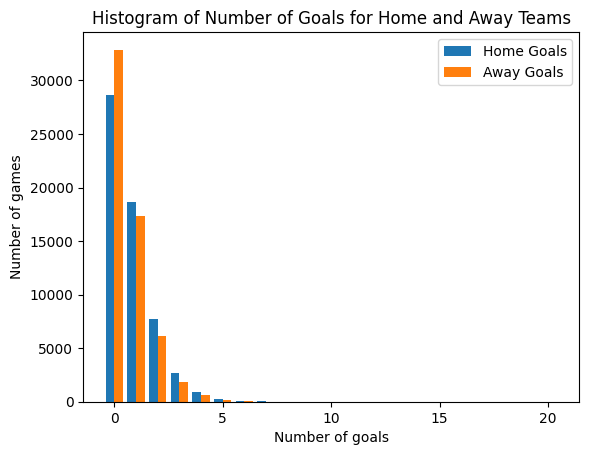

In [19]:
home_goals = y["home_goals"].values
away_goals = y["away_goals"].values
plt.hist([home_goals, away_goals], bins=np.arange(0, max(max(home_goals), max(away_goals)) + 1) - 0.5, label=['Home Goals', 'Away Goals'])
plt.legend()
plt.ylabel('Number of games')
plt.xlabel('Number of goals')
plt.title('Histogram of Number of Goals for Home and Away Teams')
y.describe()


Describing the output values, shows that the distribution is skewed and the median number of goals is around 1, so we expect the results to be biased towards 1 goal. To overcome this problem we can smaple more from the dataset to diversify the game scenarios.

Also any number of goals above 5 seems like an outlier and in further analysis, these outliers can be removed. 

#### Visualization of the dataset

In [48]:
X.describe()

home_goals    away_goals  home_corners  away_corners  \
count  59044.000000  59044.000000  59044.000000  59044.000000   
mean       0.690197      0.544729      2.306043      1.939655   
std        0.957465      0.849923      2.031749      1.823310   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      1.000000      1.000000   
50%        0.000000      0.000000      2.000000      2.000000   
75%        1.000000      1.000000      3.000000      3.000000   
max       21.000000     14.000000     17.000000     14.000000   

       mean_goal_h_intervals  std_goal_h_intervals  mean_goal_a_intervals  \
count           59044.000000          59044.000000           59044.000000   
mean                2.848858              0.368549               2.097311   
std                 8.285841              2.010392               7.349854   
min                 0.000000              0.000000               0.000000   
25%                 0.000000              0.000000               0.000000   
50%                 0.000000              0.000000               0.000000   
75%                 0.000000              0.000000               0.000000   
max                75.000000             34.000000              74.000000   

       std_goal_a_intervals  mean_corner_h_intervals  std_corner_h_intervals  \
count          59044.000000             59044.000000            59044.000000   
mean               0.236418                 7.039667                2.634731   
std                1.653254                 9.128923                4.445749   
min                0.000000                 0.000000                0.000000   
25%                0.000000                 0.000000                0.000000   
50%                0.000000                 4.000000                0.000000   
75%                0.000000                11.000000                4.500000   
max               33.000000                73.000000               33.000000   

       ...   goal_a_freq  corner_h_freq  corner_a_freq     time_gone  \
count  ...  59044.000000   59044.000000   59044.000000  59044.000000   
mean   ...      0.011699       0.050854       0.042594     44.979033   
std    ...      0.019236       0.042243       0.038422     20.477965   
min    ...      0.000000       0.000000       0.000000     10.000000   
25%    ...      0.000000       0.019608       0.013158     27.000000   
50%    ...      0.000000       0.045455       0.037500     45.000000   
75%    ...      0.018868       0.074074       0.063830     63.000000   
max    ...      0.272727       0.454545       0.400000     80.000000   

          time_left  encoded_team1  encoded_team2      friendly           u21  \
count  59044.000000   59044.000000   59044.000000  59044.000000  59044.000000   
mean      45.020967    3597.476018    3847.480015      0.049743      0.014870   
std       20.477965    2126.069226    2243.889171      0.217414      0.121035   
min       10.000000       0.000000       0.000000      0.000000      0.000000   
25%       27.000000    1783.000000    1933.750000      0.000000      0.000000   
50%       45.000000    3480.000000    3722.000000      0.000000      0.000000   
75%       63.000000    5446.000000    5804.000000      0.000000      0.000000   
max       80.000000    7401.000000    7821.000000      1.000000      1.000000   

                cup  
count  59044.000000  
mean       0.066205  
std        0.248642  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 23 columns]

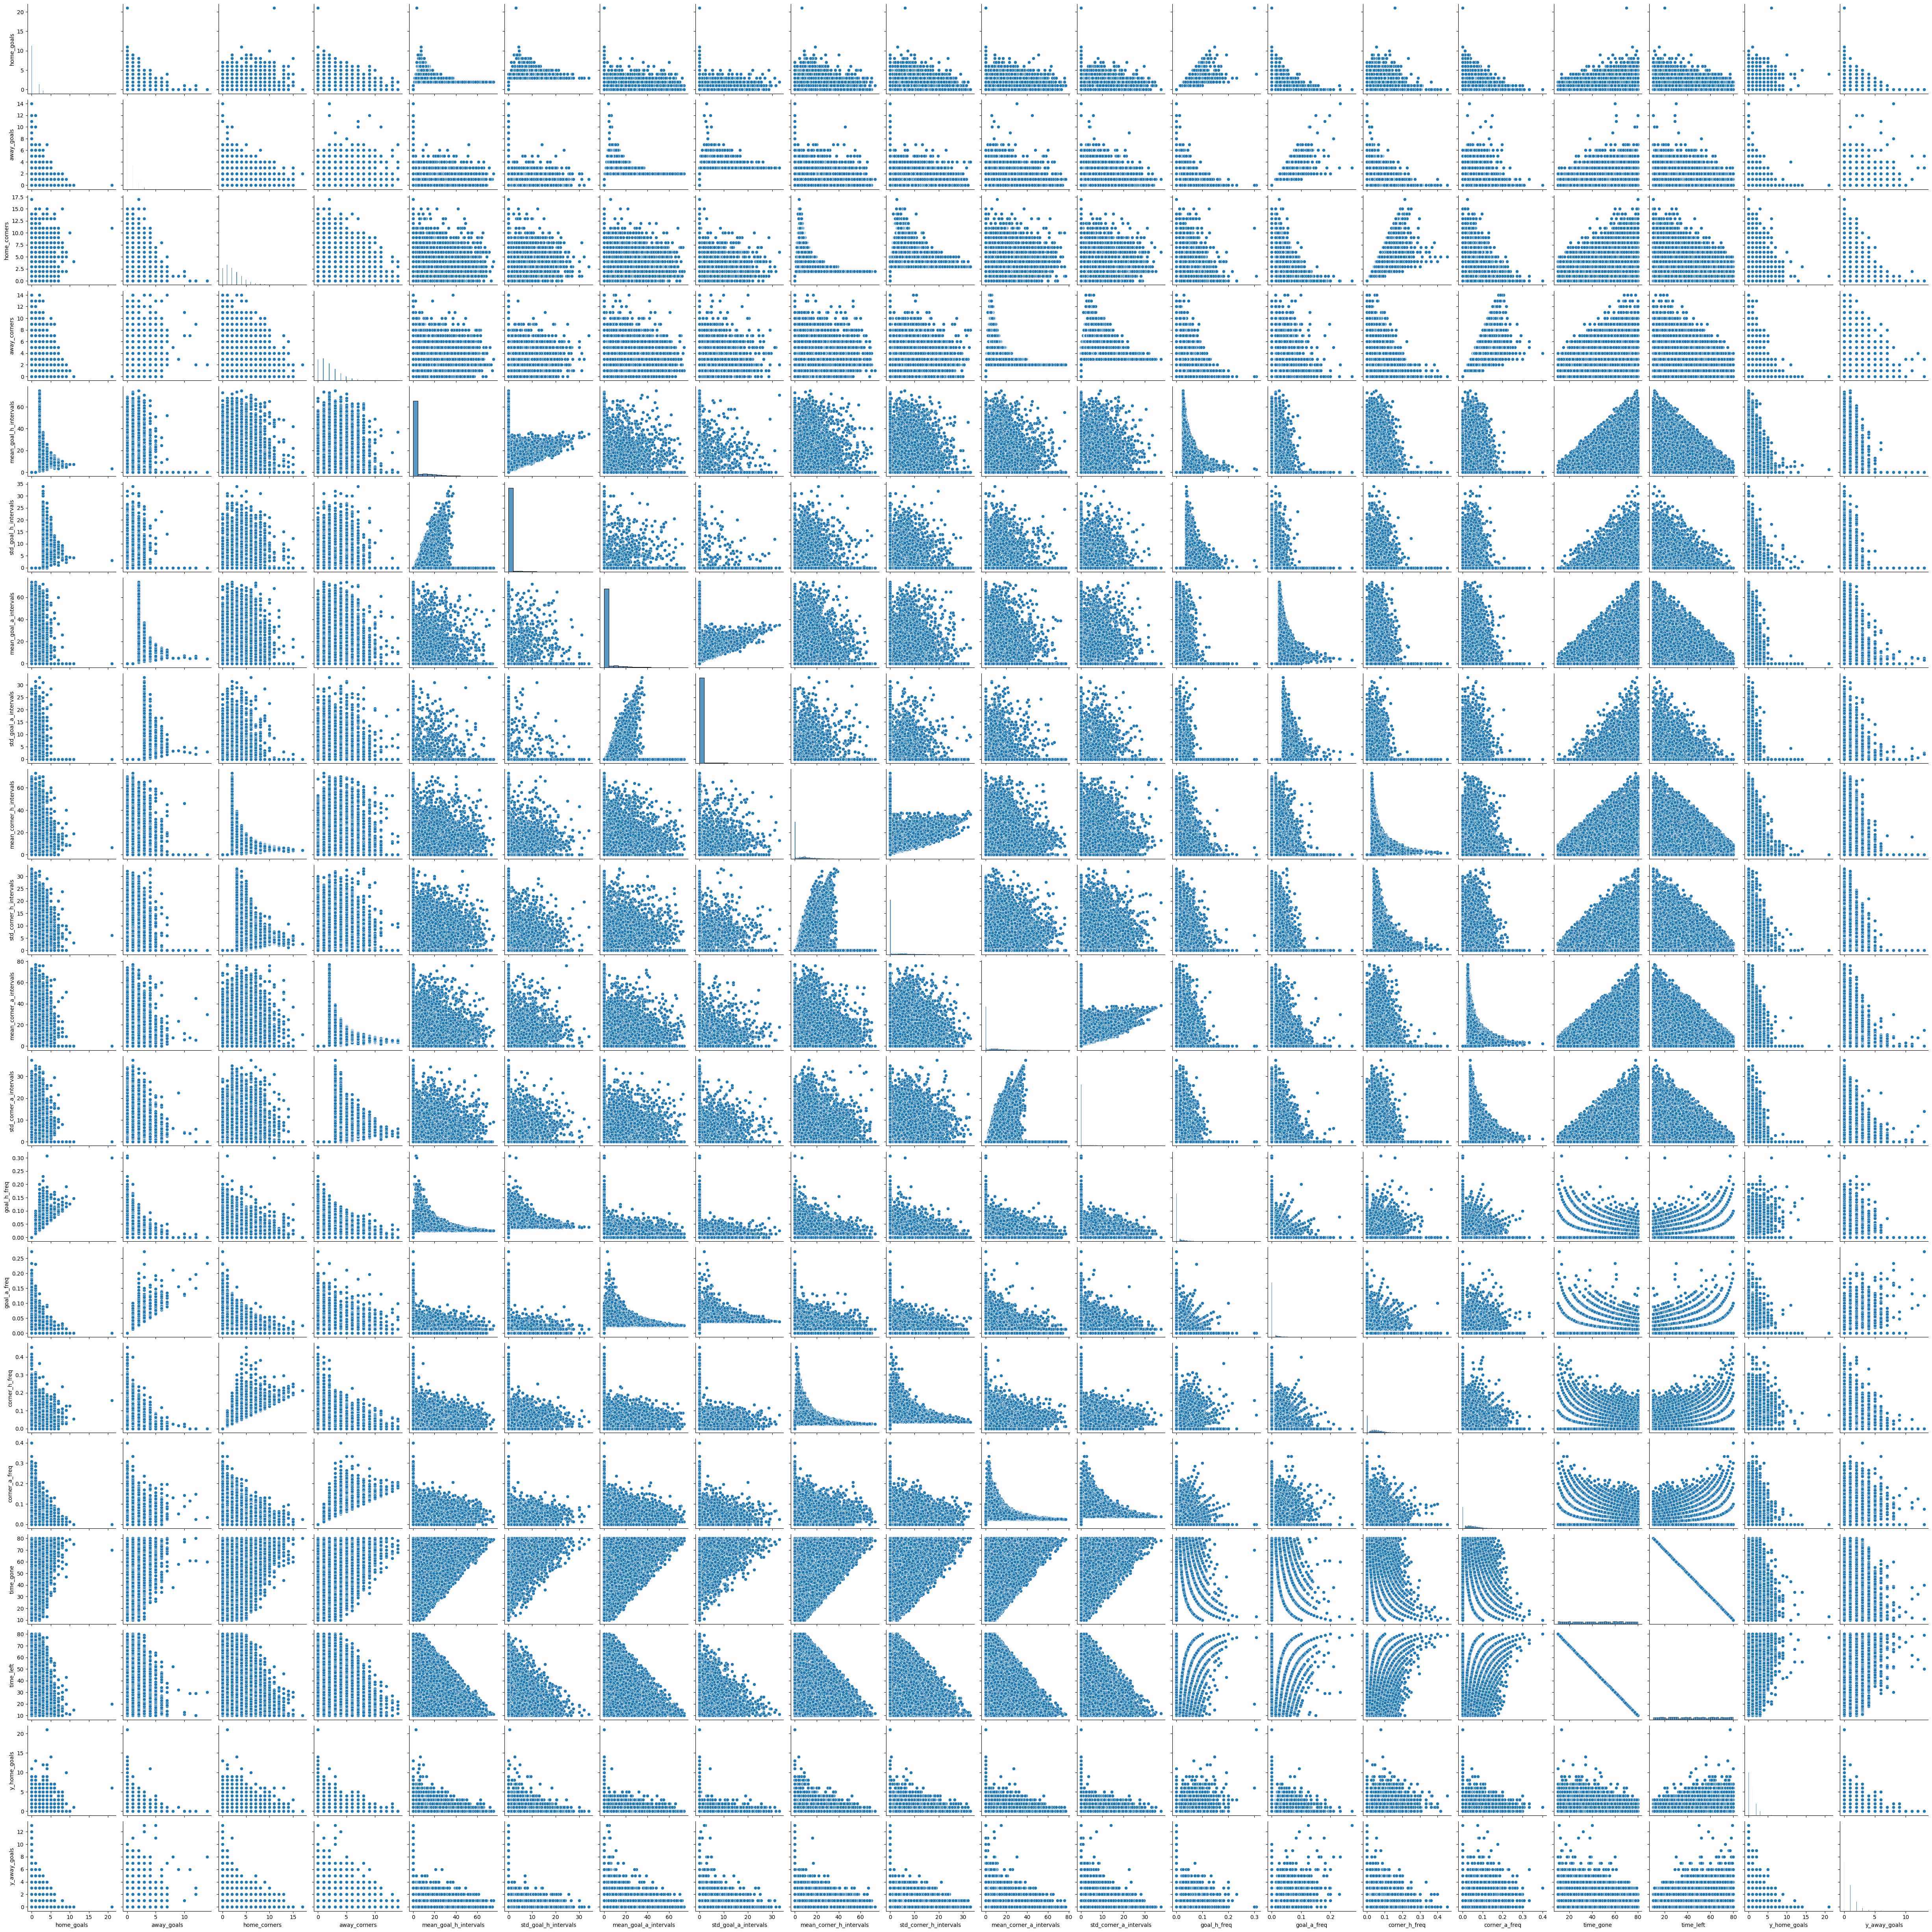

In [27]:
vis_ds = pd.concat([X.loc[:, :"time_left"], y.add_prefix("y_")], axis = 1)

sns.pairplot(vis_ds)
plt.show()

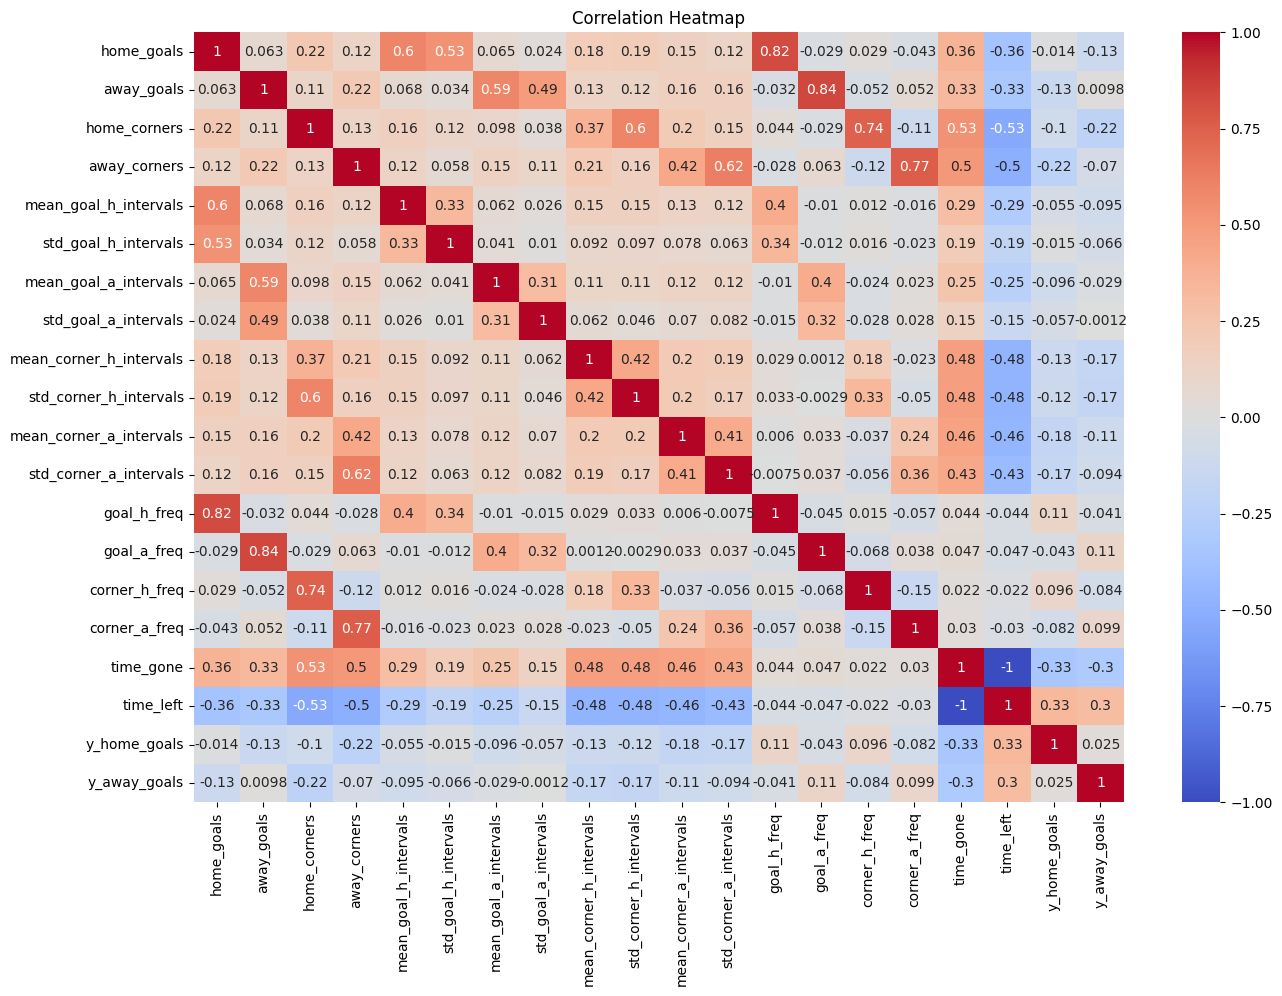

In [29]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
correlation_matrix = vis_ds.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

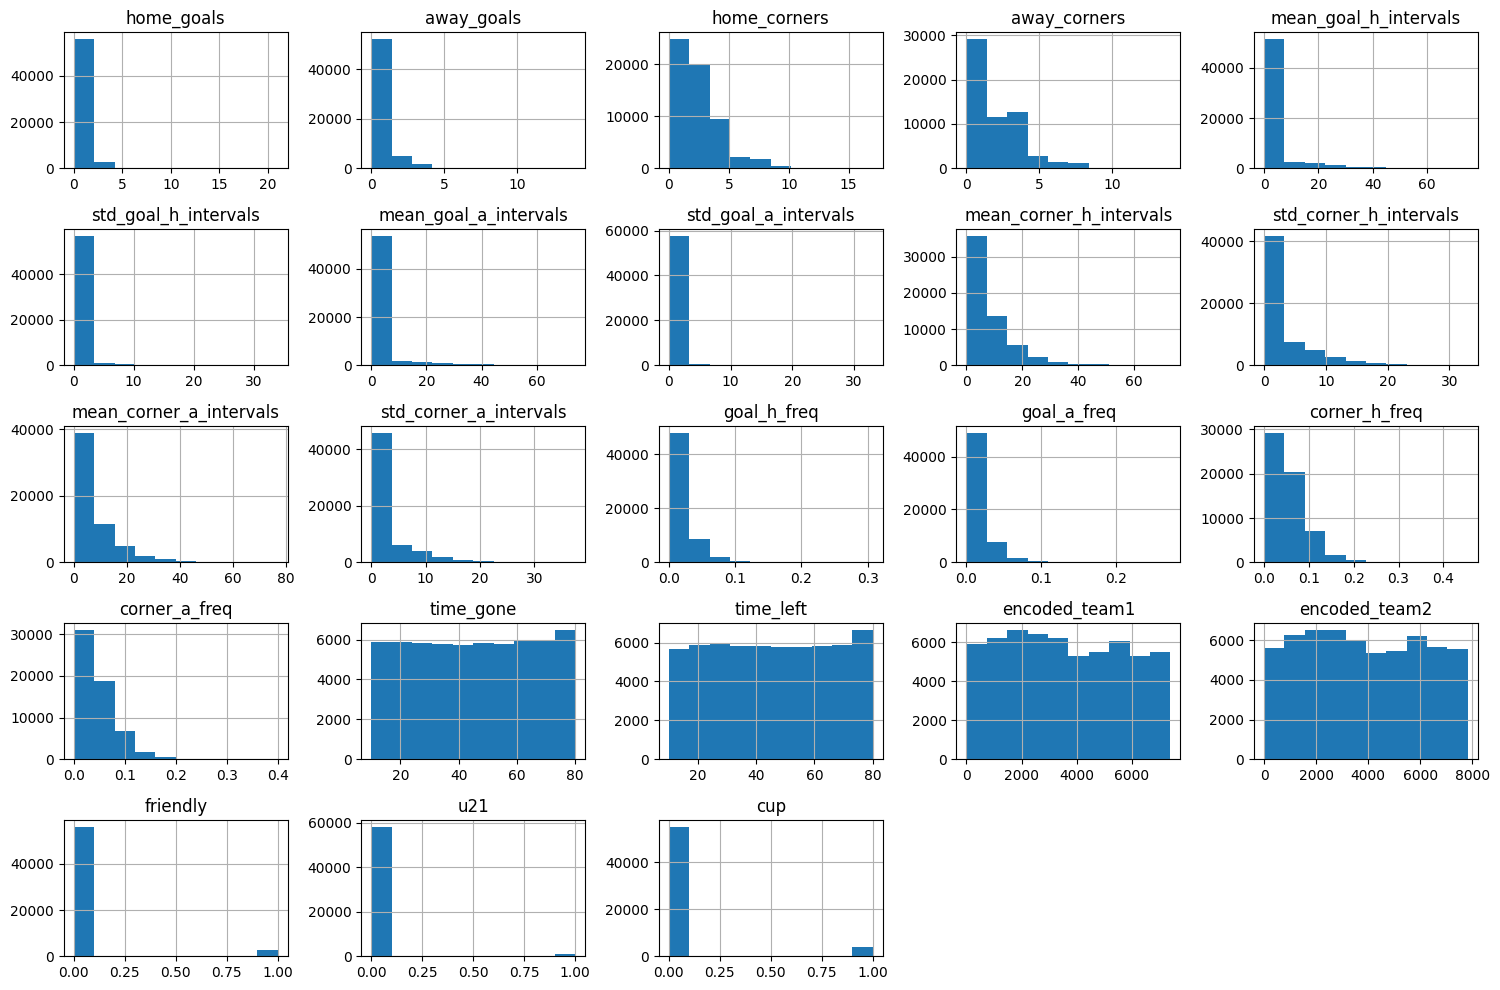

In [28]:
# Histograms
X.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

**Correlation plot:**
Based on the above diagrams, there seems to be a correlation between the home goal and intervals, however, since the task is a forecasting task, this observed correlation might not be causal when predicting next goal numbers using the past information.

Some correlation can also be observed between goals and corners which makes sense intuitively, as it indicates more pressure on the opposite team's goal.

The correlation matrix also reveals very little correlation between the league type, and teams names and the number of goals.

**Histograms plot:**
home_goals and away_goals: Both histograms show that the majority of values are concentrated around 0, indicating that most of the time, either the home or away team scores few goals.

home_corners and away_corners: Similar to the goals, most values are low, suggesting that the number of corners is also generally low for both home and away teams.

Many of the histograms are right-skewed, which might affect the performance of the regression model. Transformations such as log or square root can be done to normalize the data as a future step.

The histograms also show that the data is sparse: Both goals and corners are events that do not occur frequently, as indicated by the concentration of values at lower bins which results in challenges for the regression model, particularly in accurately capturing the variability and patterns associated with rare events. Sparse data can lead to biased estimates due to limited observations for some cases. To address this, techniques such as regularization, incorporating domain knowledge or diversifying the dataset through more samples may be necessary to improve the model's performance and robustness.

In [54]:
## store the datasets
X.to_csv('../data/X.csv')
y.to_csv('../data/y.csv')